<a href="https://colab.research.google.com/github/chaos1231107/2023_2nd_simester/blob/%EC%A0%9C%EC%A1%B0%EC%82%AC%EC%9D%B4%EB%B2%84%EB%AC%BC%EB%A6%AC%EC%8B%9C%EC%8A%A4%ED%85%9C/Audio_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pydub

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment

from pydub.playback import play

AudioSegment = '/path/to/ffmpeg'
AudioSegment = '/path/to/avcon'

In [33]:
from google.colab import drive
drive.mount('/content/drive')

f = '/content/drive/My Drive/가천대/제사/Drone1.wav'
s,a = wavfile.read(f)
print('Sampling Rate: ', s)
print('Audio Shape: ', np.shape(a))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sampling Rate:  48000
Audio Shape:  (387072, 2)


### Display Original Signal

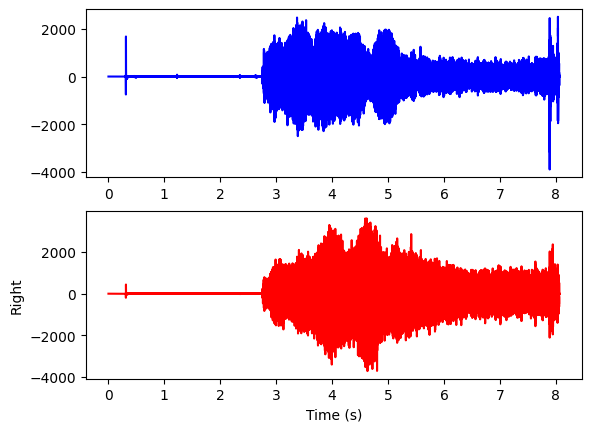

In [34]:
#number of samples
na = a.shape[0]
#audio time duration
la = na / s
t = np.linspace(0, la, na)
plt.subplot(2,1,1)
plt.plot(t, a[:,0], 'b-') #first channel(left)
plt.subplot(2,1,2)
plt.plot(t, a[:,1], 'r-') #second channel(right)
plt.ylabel('Right')
plt.xlabel('Time (s)')
plt.show()

### Convert to One Channel (Stereo to Mono)

In [35]:
from pydub import AudioSegment

# AudioSegment를 사용하여 음원 파일 로드
sound = AudioSegment.from_wav(f)
sound = sound.set_channels(1)

# 파일 이름 변경 및 WAV 형식으로 내보내기
fm = f[:-4] + '_mono.wav'
sound.export(fm, format="wav")


<_io.BufferedRandom name='/content/drive/My Drive/가천대/제사/Drone1_mono.wav'>

In [36]:
s,a = wavfile.read(fm)
print('Sampling Rate : ',s)
print('Audio Shape : ', np.shape(a))

Sampling Rate :  48000
Audio Shape :  (387072,)


### Display Mofified Audio

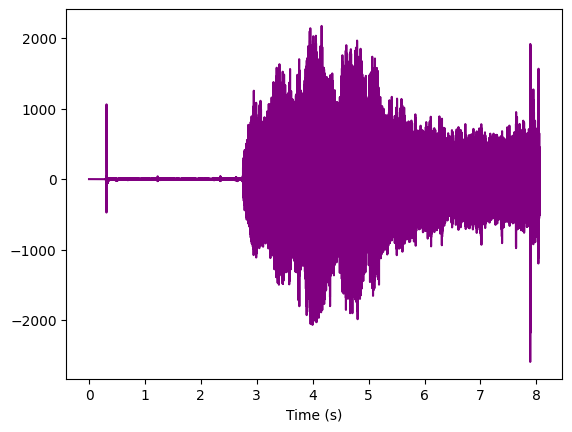

In [37]:
na = a.shape[0]
la = na / s
t = np.linspace(0, la, na)
plt.plot(t, a, '-', color='purple')
plt.xlabel('Time (s)')
plt.show()

### Frequency Analysis
### A Fast Fourier Transform (FFT) analysis

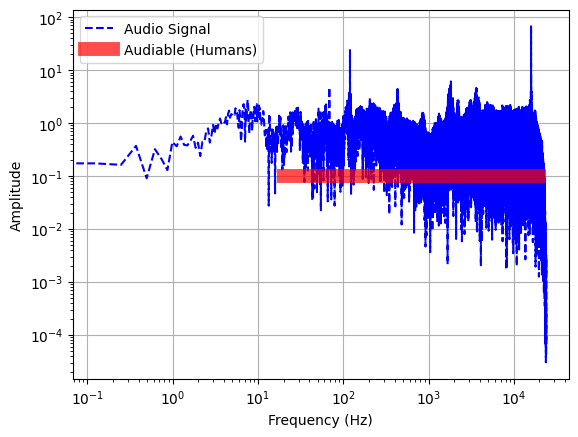

In [40]:
na = len(a)
a_k = np.fft.fft(a)[0:int(na/2)] / na
a_k[1:] = 2 * a_k[1:]
Pxx = np.abs(a_k) #remove imaginary part
f = s * np.arange((na / 2)) / na

#plotting
fig, ax = plt.subplots()
plt.plot(f, Pxx,'b--', label='Audio Signal')
plt.plot([20, 20000], [0.1,0.1], 'r-', alpha=0.7,
         linewidth=10, label='Audiable (Humans)')
ax.set_xscale('log'); ax.set_yscale('log')
plt.grid(); plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.show()

### First second clip

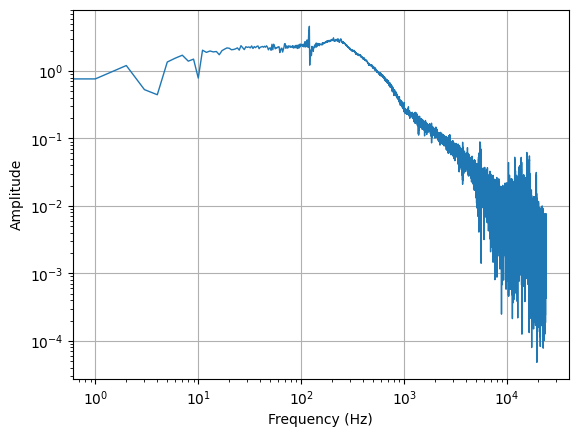

In [41]:
na = s
a_k = np.fft.fft(a[:na])[0:int(na/2)]/na
a_k[1:] = 2 * a_k[1:]
Pxx = np.abs(a_k)
f = s * np.arange((na/2))/na

fig, ax = plt.subplots()
plt.plot(f, Pxx, linewidth=1)
ax.set_xscale('log'); ax.set_yscale('log')
plt.ylabel('Amplitude'); plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

### Spectogram (time versus frequency and amplitude)

<ipython-input-48-f7556748da82>:2: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


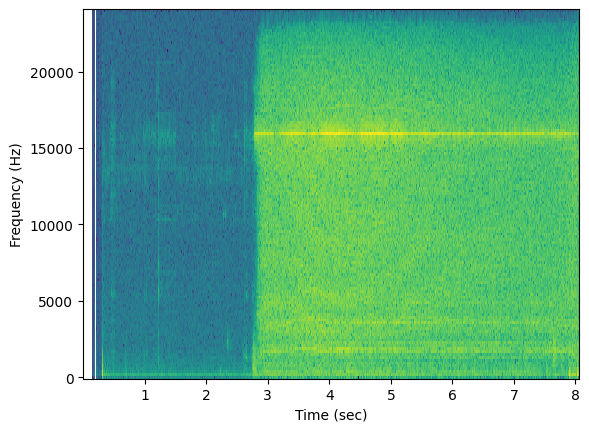

In [48]:
fr, tm, spgram = signal.spectrogram(a,s)
lspg = np.log(spgram)
plt.pcolormesh(tm,fr, lspg, shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

### Features for Machine Learning

In [42]:
print(f)
print(type(f))
np.shape(f)

[0.0000e+00 1.0000e+00 2.0000e+00 ... 2.3997e+04 2.3998e+04 2.3999e+04]
<class 'numpy.ndarray'>


(24000,)

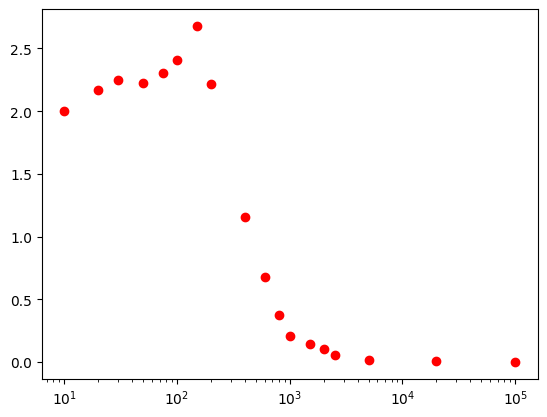

In [43]:
#주어진 주파수 범위에 대해 fft를 수행한 결과를 빈(bin) 으로 나누어서 평균을 계산하고 그 걸과를 로그 스케일로 시각화
fb = np.array([0,10,20,30,50,75,100,150,200,400,600,\
               800,1000,1500,2000,2500,5000,20000,100000])

Pb = np.zeros(len(fb)) #평균 magnitude spectrum을 계산하기 위해 최기화
nb = np.zeros(len(fb)) #주파수의 개수를 저장
ibin = 0
n = 0
for i in range(len(f)):
    if f[i] > fb[ibin+1]:
        ibin += 1
    nb[ibin] += 1
    Pb[ibin] += Pxx[i] #현재 bin에 대한 magnitude를 누적
for i in range(len(fb)):
    if nb[i] == 0:
        nb[i] = 1  # 0 으로 나누는것을 방지
    Pb[i] = Pb[i] / nb[i] #bin에 대한 평균 계산
fig,ax = plt.subplots()
plt.semilogx(fb,Pb, 'ro', linewidth=1)
plt.show()

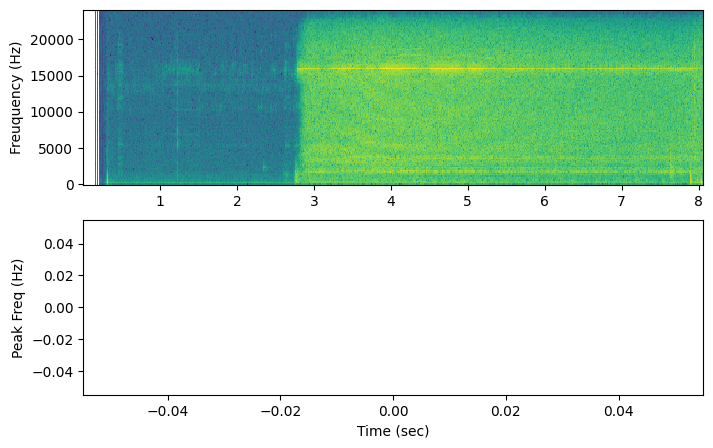

In [49]:
#analyze each sec of audio clip
nsec = int(np.floor(na))
pf = np.empty(nsec)
for i in range(nsec):
    audio = a[i*s:(i+1)*s]; na = len(audio)
    a_k = np.fft.fft(audio)[0:int(na/2)]/na
    a_k[1:] = 2 * a_k[1:]
    Pxx = np.abs(a_k)
    f = s * np.arange((na/2))/na
    ipf = np.argmax(Pxx)
    pf[i] = f[ipf]

plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.pcolormesh(tm, fr, lspg, shading='auto')
plt.ylabel('Freuquency (Hz)')
plt.subplot(2,1,2)
tb = np.arange(0,nsec)
plt.bar(tb, pf)
plt.xlabel('Time (sec)'); plt.ylabel('Peak Freq (Hz)')
plt.show()